### $\mathcal{Note}$
为了代码的简洁性，模仿了原代码的`src`文件夹，定义了大量辅助函数：
- `phase_utils.py` — `phase_demodulate`（相位解调）、`module_wise_NN_2d_complex`（单向量复数grid attractor）、`gridCAN_2d_complex`（批量复数grid attractor）
- `place_denoiser.py` — `PlaceAttractorDenoiser`（纯numpy最近邻，用于容量测试）和 - `PlaceHopfieldDenoiser`（torch版，从原notebook提取）
- `complex_capacity_utils.py` — `dynamics_gs_vectorized_patts_complex`（复数VH动力学）、`senstrans_gs_vectorized_patts_complex`（对标实数版同名函数）、`capacity_complex`（Np扫描入口）

## Storage Test (Complex VH with Place Attractor)

复数版本的 Vector-HASH 存储容量测试。对应实数版本的 `Storage_test_Fig_3.ipynb`。

**关键区别:**
1. **Phased codebooks**: gbook 和 pbook 乘以 $e^{i\phi}$ 扩展为 4D 然后 flatten，总位置数 $N_{total} = N_{pos} \times n_{ph}$
2. **容量扩大**: $N_s = N_{total}$，sbook 为 $(N_s, N_s)$，测试容量是否从 $N_p$ 扩大到 $\sim 2N_p$
3. Place cell 吸引子动力学 (nearest neighbor denoiser)
4. Grid attractor 支持复数相位解调 (phase demodulation)
5. S↔P 使用 **split** 方式:
   - $W_{ps,cos}$, $W_{ps,sin}$: 在 phased pbook 上分别对实部和虚部做伪逆
   - $W_{sp,split}$: 在拼接的 $[\text{Re}(p); \text{Im}(p)]$ 上做伪逆
6. Wgp / Wpg 仍在 real base pbook/gbook 上训练（相位因子可分离）

**3D → 1D Reshape 顺序 (C-order):**
$$\text{flat\_idx} = \text{pos\_idx} \times n_{ph} + \text{phi\_idx}$$

**Pipeline:**
$$s_i \xrightarrow{W_{ps,cos}, W_{ps,sin}} p_{re} + j \cdot p_{im} \xrightarrow{\text{Place Attractor}} p_{clean} \rightarrow W_{gp} \rightarrow g_{noisy} \xrightarrow{\text{Grid Attractor}} g_{clean} \rightarrow W_{pg} \rightarrow p_{raw} \xrightarrow{\text{phase demod + nonlin}} \xrightarrow{\text{Place Attractor}} p_{final} \xrightarrow{W_{sp,split}[\text{Re};\text{Im}]} s_{recon}$$

In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# 确保项目根目录在 Python 路径中
project_root = os.path.abspath('.')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from numpy.random import randn, randint
from src.assoc_utils_np import gen_gbook, nonlin
from src.data_utils import *
from src_complex.complex_capacity_utils import (
    capacity_complex,
    senstrans_gs_vectorized_patts_complex,
    auto_select_phis,
    harmonic_dim,
    random_expand_from_base
)

print("Imports successful!")

Imports successful!


### 超参数设置
- $N_s = N_{pos} \times n_{ph}$, sbook $(N_s, N_s)$
- Npatts 范围扩展到 $N_s = N_{patts}=kN_{pos}$，用以验证复数 VH 相较实数版本的容量扩大效果。$k$是`len(phis)`。
- $ kN_h \geq N_{patts}=kN_{pos} \Rightarrow N_h \geq N_{pos}$，$N_h$是原本的海马体细胞数量。

In [5]:
np.random.seed(41)
lambdas = [3,4]                       # module period
M = len(lambdas)                           # num modules
Ng = np.sum(np.square(lambdas))            # num grid cells
Npos_1d = np.prod(lambdas)
Npos = Npos_1d * Npos_1d                   # base spatial positions (24×24 = 576)
gbook = gen_gbook([l**2 for l in lambdas], Ng, Npos)

# Phase config — 自动选择相位
# 只需指定相位数量 Num_phi，程序自动选择满足无谐波碰撞条件的相位值
Num_phi = 5
phis = auto_select_phis(Num_phi)
nph = Num_phi
dim_mult = harmonic_dim(nph)

# Total "locations" in flattened space: Npos × nph
Ntotal = Npos * nph
Ns = Ntotal                                # num sensory cells = total locations



# Np_lst = np.arange(20,162,42)
Np_lst = [38,144]
pflip = 0.0                                # noise on sensory input
Niter = 1                                  # attractor iterations
nruns = 1
sparsity = 0                               # dummy, unused

# Random binary sensory patterns: (Ns, Ns) = (Ntotal, Ntotal)
sbook = np.sign(randn(Ns, Ns))

# Pattern count sweep up to Ns (= Ntotal = Npos * nph)
Npatts_lst = np.arange(10, Ns+1 , 18)

print(f"Grid: lambdas={lambdas}, Ng={Ng}, Npos={Npos}")
print(f"Num_phi={Num_phi}, auto-selected phis={phis}")
print(f"dim_mult={dim_mult} (H' dim = dim_mult × Np)")
print(f"Ntotal (Npos × nph) = {Ntotal}, Ns = {Ns}")
print(f"sbook shape: {sbook.shape}")
print(f"Np_lst: {Np_lst}")
print(f"Npatts_lst: {Npatts_lst} (len={len(Npatts_lst)}, max={Npatts_lst[-1]})")
print(f"nruns={nruns}, Niter={Niter}, pflip={pflip}")

Grid: lambdas=[3, 4], Ng=25, Npos=144
Num_phi=5, auto-selected phis=[0.07853982 0.31415927 0.54977871 0.78539816 1.02101761]
dim_mult=5 (H' dim = dim_mult × Np)
Ntotal (Npos × nph) = 720, Ns = 720
sbook shape: (720, 720)
Np_lst: [38, 144]
Npatts_lst: [ 10  28  46  64  82 100 118 136 154 172 190 208 226 244 262 280 298 316
 334 352 370 388 406 424 442 460 478 496 514 532 550 568 586 604 622 640
 658 676 694 712] (len=40, max=712)
nruns=1, Niter=1, pflip=0.0


### Capacity 测试 (Complex VH)


进度显示：
1. `l = ` 外层循环，遍历不同 Np 值
2. 进度条为 Npatts_lst 的内层循环
   
<div align="center">

| 变量 | 对应步骤 | 含义 |
|:---:|:---|:---|
| `err_pc` | attractor 迭代结束后 | $\|p_{out} - p_{true}\|_2 / N_p$，place cell 重建误差 |
| `err_gc` | 最后一次 grid attractor 后 | $\|g_{out} - g_{true}\|_2 / N_g$，grid cell 重建误差 |
| `err_sens` | 最终 $W_{sp} \rightarrow$ sign 后 | $\|s_{out} - s_{true}\|_2 / N_s$，sensory L2 误差 |
| `err_sensl1` | 同上 | $\text{avg}(\|s_{out} - s_{true}\|)/2$，用于 MI 计算 |
| `err_senscup` | — | 未使用，占位 NaN |

</div>

In [6]:
# S↔P 学习方式:
#   'cca'   — S→P 和 P→S 都在 H' 上做伪逆
# Flatten mode:
#   'phi_first' — phi 变化最快: idx = pos * nph + phi
#                 同一位置的不同相位连续排列
#   'map_first' — pos 变化最快: idx = phi * Npos + pos
#                 同一相位的完整地图连续排列
# Expand mode:
#   'fourier' — Fourier 谐波展开: H' = [Re, Im, cos(2φ)·p, sin(2φ)·p, ...]
#   'random'  — 随机展开: H' = [Re, Im, R₁, R₂, ...], Rⱼ iid Gaussian

ps_learn = 'cca'
expand_mode = 'fourier'   # 'fourier' or 'random'

# Complex VH capacity test (with H' expansion and place attractor denoiser)
err_pc, err_gc, err_sens, err_senscup, err_sensl1, H_prime_all = capacity_complex(
    senstrans_gs_vectorized_patts_complex,
    lambdas, Ng, Np_lst, pflip, Niter, Npos,
    gbook, Npatts_lst, nruns, Ns, sbook, sparsity,
    Num_phi=Num_phi, mode='phi_first', ps_learn=ps_learn, grid_attractor='nn',
    expand_mode=expand_mode
)

l = 0
thresh=0.5
nph=5, Ntotal=720, mode=phi_first, ps_learn=cca, dim_mult=5, H_prime shape=(1, 190, 720), expand_mode=fourier, phis=[0.07853982 0.31415927 0.54977871 0.78539816 1.02101761]


100%|██████████| 40/40 [00:05<00:00,  7.98it/s]


l = 1
thresh=0.5
nph=5, Ntotal=720, mode=phi_first, ps_learn=cca, dim_mult=5, H_prime shape=(1, 720, 720), expand_mode=fourier, phis=[0.07853982 0.31415927 0.54977871 0.78539816 1.02101761]


100%|██████████| 40/40 [00:06<00:00,  6.44it/s]


### Mutual Information 绘图

与 `Storage_test_Fig_3.ipynb` 相同的 MI 计算方式：
$$m = 1 - 2 \cdot \text{err\_sensl1}$$
$$S = -\frac{1+m}{2}\log_2\frac{1+m}{2} - \frac{1-m}{2}\log_2\frac{1-m}{2}$$
$$\text{MI} = 1 - S$$

/tmp/ipykernel_244266/194274562.py:13: RuntimeWarning: divide by zero encountered in log2
  S = - a * np.log2(a) - b * np.log2(b)
/tmp/ipykernel_244266/194274562.py:13: RuntimeWarning: invalid value encountered in multiply
  S = - a * np.log2(a) - b * np.log2(b)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following famil

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

Npatts shape: (40, 1)
m shape: (4, 40, 1)


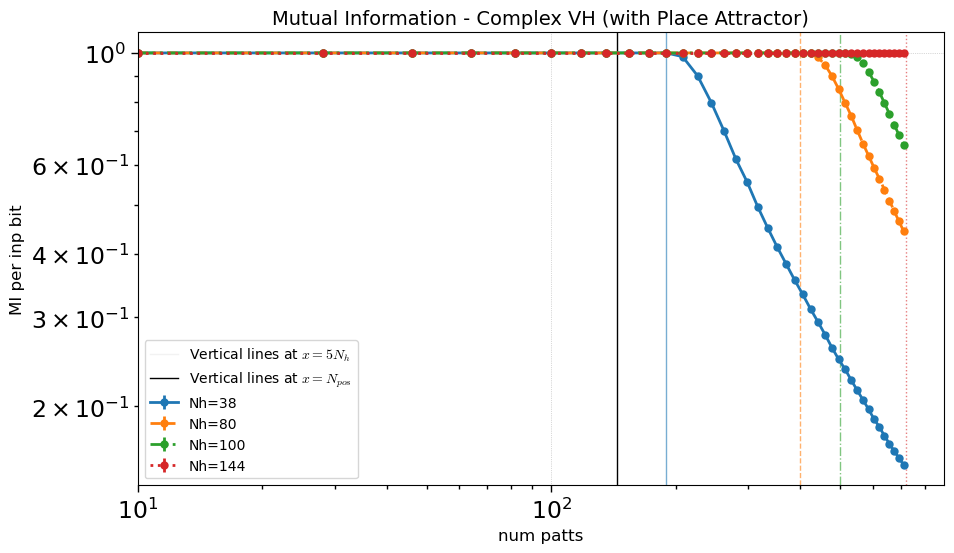

In [10]:
### FOR BINARY PATTS
normlizd_l1 = err_sensl1
Npatts = np.array(nruns * [Npatts_lst])   # Npatts_lst repeated nruns times
Npatts = Npatts.T
print(f"Npatts shape: {Npatts.shape}")

m = 1 - (2 * normlizd_l1)
print(f"m shape: {m.shape}")

a = (1 + m) / 2
b = (1 - m) / 2

S = - a * np.log2(a) - b * np.log2(b)
S = np.where(m == 1, np.zeros_like(S), S)

MI = 1 - S

plt.figure(figsize=(10, 6))

styles = ['-', '--', '-.', ':']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

for l, Np in enumerate(Np_lst):
    linestyle = styles[l % len(styles)]
    color = colors[l % len(colors)]
    plt.errorbar(Npatts_lst, MI[l].mean(axis=1), yerr=MI[l].std(axis=1),
                 lw=2, label=f'Nh={Np}', marker='o', markersize=4,
                 linestyle=linestyle, color=color)
    # plt.axvline(x=Np, linestyle=linestyle, color=color, alpha=0.6)
    # plt.axvline(x=2*Np, linestyle=linestyle, color=color, alpha=0.6)
    # if l< 2:
    #     plt.axvline(x=4*Np, linestyle=linestyle, color=color, alpha=0.6)
    plt.axvline(x=(Num_phi)*Np, linestyle=linestyle, color=color, alpha=0.6)

# 添加虚拟垂直线用于图例说明（注意：你代码里写的是 x=Np，但你说要在 x=3Np 处？
# 如果确实是 x=3Np，请把上面的 axvline 改为 x=3*Np）
plt.axvline(x=np.nan, color='gray', linestyle='-', alpha=0.1, 
            label=f'Vertical lines at $x = {Num_phi}N_h$')
plt.axvline(x=144, color='black', linestyle='-', alpha=1, 
            label=r'Vertical lines at $x = N_{pos}$')

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin=10)
plt.ylabel('MI per inp bit', fontsize=12)
plt.xlabel('num patts', fontsize=12)
plt.title('Mutual Information - Complex VH (with Place Attractor)', fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 详细误差分析

分别查看 Place Cell、Grid Cell 和 Sensory 的重建误差。

/tmp/ipykernel_232526/2712254223.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were foun

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

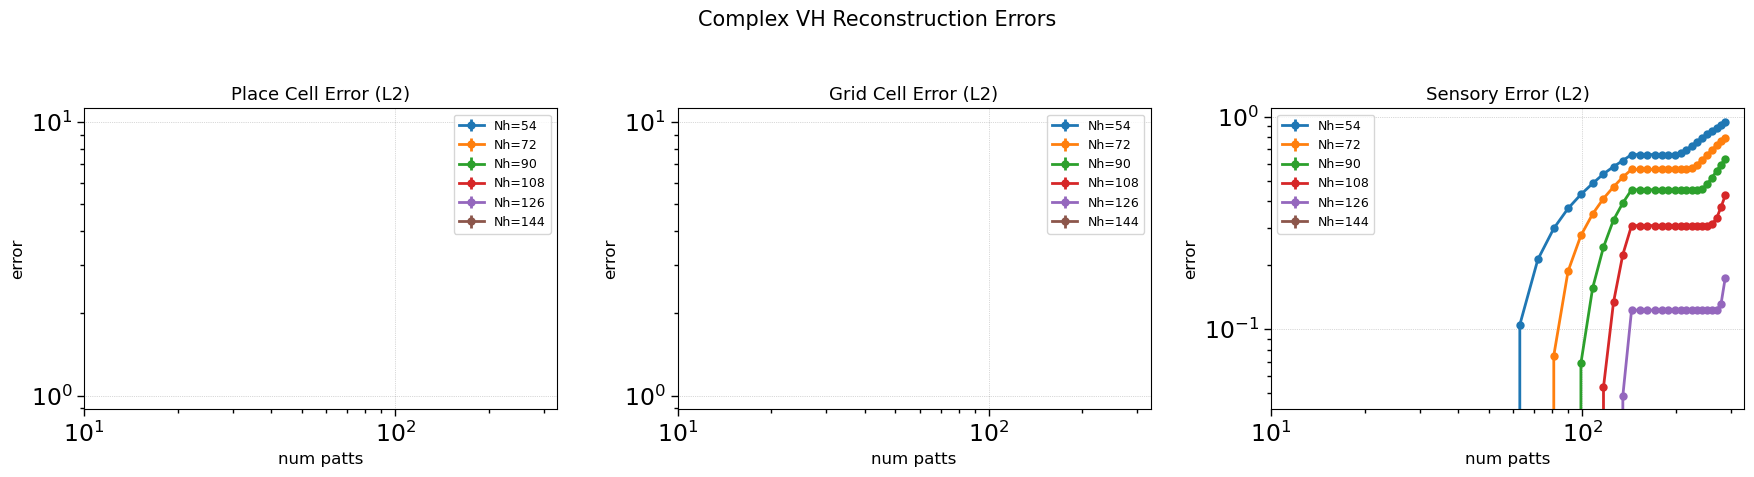

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

titles = ['Place Cell Error (L2)', 'Grid Cell Error (L2)', 'Sensory Error (L2)']
data = [err_pc, err_gc, err_sens]

for ax, title, err_data in zip(axes, titles, data):
    for l, Np in enumerate(Np_lst):
        ax.errorbar(Npatts_lst, err_data[l].mean(axis=1),
                    yerr=err_data[l].std(axis=1),
                    lw=2, label=f'Nh={Np}', marker='o', markersize=4)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(10)
    ax.set_xlabel('num patts', fontsize=12)
    ax.set_ylabel('error', fontsize=12)
    ax.set_title(title, fontsize=13)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Complex VH Reconstruction Errors', fontsize=15)
plt.tight_layout()
plt.show()

## 测试流程解读
---
两个主要函数`senstrans_gs_vectorized_patts_complex`和`dynamics_gs_vectorized_patts_complex` ，前者外层，后者内层。
### `senstrans_gs_vectorized_patts_complex`
对单个 Np 的完整实验

这是核心准备层，一次性生成所有 codebook 和权重，然后扫描不同的 Npatts。

#### Step 1: 相位解析

``` python
phis_arr = auto_select_phis(Num_phi)   # e.g. Num_phi=5 → 5个无谐波碰撞的相位
Ntotal = Npos * nph                    # 总 pattern 数 (如 144×5 = 720)
dim_mult = max(1, nph)                 # H' 维度倍增器 (如 nph=5 → 5)
```

------------------------------------------------------------------------

#### Step 2: 生成 G↔P 系统的权重

``` python
Wpg = randn(nruns, Np, Ng) * sparse_mask      # 随机稀疏 g→p 投影（固定，不学习）
pbook_base = nonlin(Wpg @ gbook, thresh)     # (nruns, Np, Npos) – 实值 place codebook
Wgp = gbook @ pinv(pbook_base)               # (nruns, Ng, Np) – 伪逆学习 p→g
```

**关键点：**

-   Wpg 是随机固定的（模拟生物学中的 grid--place 固定连接）
-   Wgp 是学习得到的（伪逆 -- 最小二乘最优解）
-   两者仅在 real base pbook (Np × Npos) 上操作，与相位无关

------------------------------------------------------------------------

#### Step 3: 构建辅助 codebook
<div align="center">

| Codebook | 形状 | 用途 |
|---------|------|------|
| `module_gbooks` | list of $(\lambda_i^2, N_{pos})$ | Grid NN attractor 的 per-module 参考 |
| `gbook_phased` | $(N_g, N_{total})$, complex | Grid error 计算的 ground truth: $g_j \cdot e^{i\varphi}$ |
| `H_prime_book` | $(n_{runs}, d \cdot N_p, N_{total})$, real | 展开后的 place codebook |

</div>
H' 构建两种模式

-   **Fourier**\
    `fourier_expand_from_base(pbook_base, phis)`\
    用谐波 cos(kφ), sin(kφ) 展开

-   **Random**\
    `random_expand_from_base(pbook_base, phis)`\
    前 2Np 同 Fourier，额外维度填 iid Gaussian

------------------------------------------------------------------------

#### Step 4: 初始化 denoiser

``` python
denoiser = PlaceAttractorDenoiser()  # 纯 numpy NN denoiser，在 H' 空间工作
```

------------------------------------------------------------------------

### `dynamics_gs_vectorized_patts_complex` 
单次动力学全流程

输入：\
`s_init (nruns, Ns, Npatts)`，要重建的 sensory pattern。

------------------------------------------------------------------------

#### Phase A: Sensory → Place（初始解码）

``` text
s_in —Wps→ H'_pred (nruns, dim_mult·Np, Npatts)
        ↓
    denoiser.denoise()     ← H' 空间 NN: 找最近存储 pattern
        ↓
    collapse(H'→p)        ← 取前 2Np 维:
                             p = H'[:Np] + j·H'[Np:2Np]
        ↓
    p_complex (nruns, Np, Npatts) complex
```

------------------------------------------------------------------------

#### Phase B: Place ↔ Grid 迭代（重复 Niter 次）

``` python
for i in range(Niter):
    ┌─── p_complex ───┐
    │                  │
    │  ① Wgp @ p       │→ gin (nruns, Ng, Npatts) complex
    │                  │
    │  ② Grid Attractor │→ g_clean
    │     • 'nn':  phase_demodulate → module-wise NN → re-phase
    │     • 'argmax': phase_demodulate → per-module argmax → re-phase
    │                  │
    │  ③ Wpg @ g       │→ p_raw (nruns, Np, Npatts) complex
    │                  │
    │  ④ phase_demod    │→ 解调出 |p| 和 φ_hat
    │    + nonlin(thresh)│→ 稀疏化 (ReLU-like, thresh=0.5)
    │    + re-phase     │→ p = |p_clean| · e^{iφ_hat}
    │                  │
    │  ⑤ expand(p→H')  │→ 从 complex p 重建完整 H'
    │     • fourier: 用已知 per-column phase 乘谐波
    │     • random:  [Re;Im] + NN lookup cached random blocks
    │                  │
    │  ⑥ denoiser(H')  │→ H' 空间最近邻去噪
    │                  │
    │  ⑦ collapse(H'→p)│→ 更新 p_complex
    └──────────────────┘
```

 Grid Attractor 细节（以 'nn' 模式为例）

1.  接收 `g_in = Wgp · p`
2.  `phase_demodulate(g_in)` → 分离带符号幅度 \|g\|\_signed 和全局相位 φ̂
3.  若已知 phis，将 φ̂ snap 到最近已知相位
4.  在实值空间做 module-wise NN（每个 module 独立）
5.  重建：\
    `g_clean = g_real · e^{iφ}`

------------------------------------------------------------------------
Place Attractor（denoiser）细节

-   存储 Npatts 个 H' pattern（每个 d·Np 维向量）
-   计算 cosine similarity
-   选择最近邻替换
-   属于离散吸引子

------------------------------------------------------------------------

#### Phase C: Place → Sensory（最终解码）

``` text
p_complex —expand→ H'_final —Wsp→ sign() → s_recon
```

------------------------------------------------------------------------

#### Phase D: 误差计算

<div align="center">

| 变量 | 对应步骤 | 含义 |
|:---:|:---|:---|
| `err_pc` | attractor 迭代结束后 | $\|p_{out} - p_{true}\|_2 / N_p$，place cell 重建误差 |
| `err_gc` | 最后一次 grid attractor 后 | $\|g_{out} - g_{true}\|_2 / N_g$，grid cell 重建误差 |
| `err_sens` | 最终 $W_{sp} \rightarrow$ sign 后 | $\|s_{out} - s_{true}\|_2 / N_s$，sensory L2 误差 |
| `err_sensl1` | 同上 | $\text{avg}(\|s_{out} - s_{true}\|)/2$，用于 MI 计算 |
| `err_senscup` | — | 未使用，占位 NaN |

</div>


### 全流程图

```python

                    ┌─────────── 准备阶段 (senstrans) ───────────┐
                    │                                             │
    gbook ─────Wpg(random)────→ pbook_base ──expand──→ H'_book   │
    (Ng,Npos)  (Np,Ng)          (Np,Npos)      │     (d·Np,Ntotal)
         │                          │           │         │
         │                     pinv(P)          │    Wsp = s·pinv(H')
         │                          │           │    Wps = H'·pinv(s)
         └────── Wgp = G·P⁺ ───────┘           │         │
                  (Ng,Np)                       │         │
                    │                    denoiser.store(H')│
                    │                           │         │
                    └───────────────────────────┼─────────┘
                                                │
                    ┌─── 动力学 (dynamics) ──────┘
                    │
    s_init ──Wps──→ H' ──denoiser──→ H' ──collapse──→ p
                                                       │
                          ┌────────────────────────────┘
                          │ (repeat Niter times)
                          ↓
                    p ──Wgp──→ g_noisy ──GridAttractor──→ g_clean
                                                           │
                    p ←─demod+nonlin──←─Wpg────────────────┘
                    │
                    p ──expand──→ H' ──denoiser──→ H' ──collapse──→ p
                          │ (end loop)
                          ↓
                    p ──expand──→ H' ──Wsp──→ sign() → s_recon
                                                         │
                                                    compare with s_true

```
